# The Woof Factor in Zürich
---

Through use of data freely available from *Stadt Zürich Open Data*, we analyse dogs registered in Zurich and combine this data with other information available about the districts (kreis) that make up Zurich. A model is developed in which we ...

*Project Group 23:* Corey Bothwell, Nicoletta Farabullini, Jacob Gelling, Andris Prokofjevs, Qasim Warraich

# Libraries
---

The required packages must first be installed. On Linux, this requires the system to have Curl (for communicating with the Yandex Translate API) and GDAL (for generating the map vizualisations) installed.

In [ ]:
install.packages("readr")
install.packages("data.table")
install.packages("RYandexTranslate")
install.packages("plyr")
install.packages("dplyr")
install.packages("stringr")
install.packages("class")
install.packages("e1071")
install.packages("ggplot2")
install.packages("reshape2")
install.packages("leaflet")
install.packages("rgdal")
install.packages("stringi")

Libraries used throughout the analysis are imported here.

In [1]:
library(readr)
library(data.table)
library(RYandexTranslate)
library(plyr)
library(dplyr)
library(stringr)
library(class)
library(e1071)
library(ggplot2)
library(reshape2)
library(leaflet)
library(rgdal)
library(stringi)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:plyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize


The following objects are masked from ‘package:data.table’:

    between, first, last


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘reshape2’


The following objects are masked from ‘package:data.table’:

    dcast, melt


Loading required package: sp

rgdal: version: 1.5-8, (SVN revision 990)
Geospatial Data Abstraction Library extensions to R successfully loaded
Loaded GDAL runtime: GDAL 3.0.4, released 2020/01/28
Path to GDAL shared files: /usr/share/gdal
GDAL binary built with GEOS: TRUE 
Loaded PROJ runtime: Rel. 6.3.1, February 10th, 2020, [PJ_VERSION: 631]
Path to PROJ shared files: /usr/share/proj
Linking to sp version:1.4-2
To mute warnings of possible GDAL/OSR expor

# Data Aquisition

# Data Processing and Cleaning
---

This section is used for importing the raw data from CSV files into R data tables. Appropriate data merging and cleaning is performed.

Also performed is automatic translations from German to English for some of the column content that would otherwise be too laborious to do by hand.

Rather than running data cleaning each time we run the notebook during development, which can be slow due to the Yandex Translate API, an R data image of the alreadly cleaned data provided with the Notebook file can be loaded instead by running the following block.

In [2]:
load("dogs.Rdata")

## Dog Data Aquisition

The dog registration data for 2020, for which the source is available at [Stadt Zürich Open Data](https://data.stadt-zuerich.ch/dataset/sid_stapo_hundebestand/resource/a05e2101-7997-4bb5-bed8-c5a61cfffdcf), is imported and converted to a R data table.

In [3]:
dogs2020 <- data.table(read_csv("data_sources/20200306_hundehalter.csv"))

Parsed with column specification:
cols(
  HALTER_ID = col_double(),
  ALTER = col_character(),
  GESCHLECHT = col_character(),
  STADTKREIS = col_double(),
  STADTQUARTIER = col_double(),
  RASSE1 = col_character(),
  RASSE1_MISCHLING = col_character(),
  RASSE2 = col_character(),
  RASSE2_MISCHLING = col_logical(),
  RASSENTYP = col_character(),
  GEBURTSJAHR_HUND = col_double(),
  GESCHLECHT_HUND = col_character(),
  HUNDEFARBE = col_character()
)



Data cleaning is now performed. Due to what is likely a typographical error, a dog with a district value of 8 is removed (non-existant stadtquartier).

Data we are uninterested in and rows that are incomplete are also removed, however for the 2020 dog dataset we find that 0 rows are ommited.

In [4]:
# Dog w. district "8", typographical error? We remove it.
dogs2020 <- dogs2020[(dogs2020$STADTQUARTIER!=8), ]

# Removing unnececesary columns
dogs2020[, c("RASSE1_MISCHLING", "RASSE2", "RASSE2_MISCHLING"):=NULL]

# If a row has a NA entry in one of the cells, remove the entire row
dogs2020 <- na.omit(dogs2020)
# 0 rows ommited, still leave the code in place in case we change data basis.

Due to the international makeup of our team members, we translate the column names from German to English.

In [5]:
# Rename columns
setnames(dogs2020,
         old = c("HALTER_ID", "ALTER", "GESCHLECHT", "STADTQUARTIER", "STADTKREIS",   "RASSE1", "RASSENTYP",  "GEBURTSJAHR_HUND", "GESCHLECHT_HUND", "HUNDEFARBE"),
         new = c("OWNER_ID",  "AGE",   "SEX",        "DISTRICT",      "DISTRICT_BIG", "BREED",  "BREED_TYPE", "YOB_DOG",          "SEX_DOG",         "COLOR_DOG")
        )

Because stadtquartier is a more granular district segmentation than stadtkreis, and not all datasets can be merged by stadtkreis, we used it instead. We found that it is hard to view on a map when the dataset does not contain normal district names, so we extract the district names from the wealth dataset.

In [6]:
# Import district names
district_names <- data.table(read_csv("data_sources/wir100od1004.csv"))
district_names <- unique(district_names[, QuarSort, QuarLang])

# Rename columns
setnames(district_names,
         old = c("QuarSort", "QuarLang"),
         new = c("DISTRICT", "DISTRICT_NAME")
        )

dogs2020 <- merge(dogs2020, district_names , by = "DISTRICT", all.x = T)

# Remove unused variable
rm(district_names)

Parsed with column specification:
cols(
  SteuerJahr = col_double(),
  QuarSort = col_double(),
  QuarLang = col_character(),
  SteuerTarifSort = col_double(),
  SteuerTarifLang = col_character(),
  SteuerVermoegen_p50 = col_double(),
  SteuerVermoegen_p25 = col_double(),
  SteuerVermoegen_p75 = col_double()
)



## Import Wealth Data

Next the wealth data, for which the source is available at [Stadt Zürich Open Data](https://data.stadt-zuerich.ch/dataset/fd_median_einkommen_quartier_od1003), is imported and converted to a R data table.

In [7]:
wealth <- data.table(read_csv("data_sources/wir100od1004.csv"))

Parsed with column specification:
cols(
  SteuerJahr = col_double(),
  QuarSort = col_double(),
  QuarLang = col_character(),
  SteuerTarifSort = col_double(),
  SteuerTarifLang = col_character(),
  SteuerVermoegen_p50 = col_double(),
  SteuerVermoegen_p25 = col_double(),
  SteuerVermoegen_p75 = col_double()
)



The latest data from this source is for 2017, so we select only this wealth data, store the average and aggregate the data.

In [8]:
# We don't have data for 2020, the freshest data is for 2017
wealth <- wealth[SteuerJahr == 2017,]

# Create a new column to store the average
wealth[, wealth50 := SteuerVermoegen_p50]

# Replace the family values in this column with same divided by 2 for normalization
wealth$wealth50[wealth$SteuerTarifSort == 1] <- wealth$wealth50[wealth$SteuerTarifSort == 1]/2

# Aggregate data for family status
# new table = old table, select mean of wealth50 (ignore NA), aggregate it by quartal
wealth_merge <- wealth[,mean(wealth50, na.rm = T), by=QuarSort]

# Leaving only quartals that have dogs in them
wealth_merge <- wealth_merge[wealth_merge$QuarSort %in% dogs2020$DISTRICT]

We again translate the column names from German to English and then merge the data with the dogs data table.

In [9]:
# Rename columns
setnames(wealth_merge,
         old = c("V1",           "QuarSort"),
         new = c("WEALTH_T_CHF", "DISTRICT")
        )

# Merge wealth into dogs dataset
dogs2020 <- merge(dogs2020, wealth_merge, by = "DISTRICT", all.x = T)
# ATTENTION! FYI: not all districts have wealth values! 

# Remove unused variables
rm(wealth, wealth_merge)

## Import Income Data

Next the income data, for which the source is available at [Stadt Zürich Open Data](https://data.stadt-zuerich.ch/dataset/fd_median_vermoegen_quartier_od1004), is imported and converted to a R data table.

In [10]:
income <- data.table(read_csv("data_sources/wir100od1003.csv"))

Parsed with column specification:
cols(
  SteuerJahr = col_double(),
  QuarSort = col_double(),
  QuarLang = col_character(),
  SteuerTarifSort = col_double(),
  SteuerTarifLang = col_character(),
  SteuerEInkommen_p50 = col_double(),
  SteuerEinkommen_p25 = col_double(),
  SteuerEinkommen_p75 = col_double()
)



Again, the latest data from this source is for 2017, so we select only this income data, store the average and aggregate the data.

In [11]:
# We don't have data for 2020, the freshest data is for 2017
income <- income[SteuerJahr == 2017,]

# Create a new column to store the average
income[, incomep50 := SteuerEInkommen_p50]

# Replace the family values in this column with same divided by 2 for normalization
income$incomep50[income$SteuerTarifSort == 1] <- income$incomep50[income$SteuerTarifSort == 1]/2

# Aggregate data for family status
# new table = old table, select mean of incomep50 (ignore NA), aggregate it by quartal
income_merge <- income[,mean(incomep50, na.rm = T), by=QuarSort]

# Leaving only quartals that have dogs in them
income_merge <- income_merge[income_merge$QuarSort %in% dogs2020$DISTRICT]

We again translate the column names from German to English and then merge the data with the dogs data table.

In [12]:
# Rename columns
setnames(income_merge,
         old = c("V1",           "QuarSort"),
         new = c("INCOME_T_CHF", "DISTRICT")
        )

# Merge income into dogs dataset
dogs2020 <- merge(dogs2020, income_merge, by = "DISTRICT", all.x = T)
# ATTENTION! FYI: not all districts have income values! 

# Remove unused variables
rm(income, income_merge)

## Import Education Data

The import of education data is straightforward, requiring only a long to wide reshape of the data. The data source is available at [Stadt Zürich Open Data](https://data.stadt-zuerich.ch/dataset/bfs_bev_bildungsstand_statquartier_seit1970_od1012).

In [13]:
education <- data.table(read_csv("data_sources/bil101od1012 (2).csv"))

# Long to wide education reshape
education <- dcast(education, RaumSort ~ Bildungsstand, value.var = "AntBev")

# Rename columns
setnames(education,
         old = c("RaumSort", "Obligatorische Schule",   "Sekundarstufe II",     "Tertiärstufe"),
         new = c("DISTRICT", "BASIC_SCHOOL_PERCENTAGE", "GYMNASIUM_PERCENTAGE", "UNIVERSITY_PERCENTAGE")
        )

# Merge income into dogs dataset
dogs2020 <- merge(dogs2020, education, by = "DISTRICT", all.x = T)

# Remove unused variable
rm(education)

Parsed with column specification:
cols(
  RaumSort = col_double(),
  RaumLang = col_character(),
  Bildungsstand = col_character(),
  AntBev = col_double(),
  untAntBevKI = col_double(),
  obAntBevKI = col_double()
)



## Import Home Type Data

Home type data, such as number of resident buildings in a district, is now imported. The data source is available at [Stadt Zürich Open Data](https://data.stadt-zuerich.ch/dataset/bau_best_geb_whg_bev_gebaeudeart_quartier_seit2008/resource/3850add1-264c-4993-98cd-d8a9ba87ee25). 2019 is the latest data available. Each building type is summed and a long to wide reshape of the data is performed.

In [14]:
home_type <- data.table(read_csv("data_sources/bau_best_geb_whg_bev_gebaeudeart_quartier_seit2008.csv")) 

# We don't have data for 2020, the freshest data is for 2019
home_type <- home_type[Jahr == 2019,]

# Count the sum of every type of building
home_type <- home_type[, sum(AnzGeb), by = list(QuarSort,GbdArtPubName)]

# Rename columns
setnames(home_type,
         old = c("QuarSort", "GbdArtPubName", "V1"), 
         new = c("DISTRICT", "Hometype",      "Number_homes")
        )

# Long to wide hometype reshape
home_type <- data.table::dcast(home_type, DISTRICT ~ Hometype, value.var = "Number_homes")

# Translate hometype columns
setnames(home_type,
         old = c("Produktions- und Lagergebäude", "Mehrfamilienhäuser", "Einfamilienhäuser",   "Infrastrukturgebäude",     "Kleingebäude",    "Kommerzielle Gebäude", "Spezielle Wohngebäude"), 
         new = c("FACTORIES_AND_WAREHOUSES",      "APARTMENTS",         "SINGLE_FAMILY_HOMES", "INFRASTRUCTURE_BUILDINGS", "SMALL_BUILDINGS", "COMMERCIAL_BUILDINGS", "SPECIAL_ACCOMODATION")
        )

# Remove unnececesary column
home_type[, Unbekannt:=NULL]

# Merge home types into dogs dataset
dogs2020 <- merge(dogs2020, home_type, by = "DISTRICT", all.x = T)

# Remove unused variable
rm(home_type)

Parsed with column specification:
cols(
  Jahr = col_double(),
  QuarSort = col_double(),
  QuarLang = col_character(),
  GbdArt1 = col_double(),
  GbdArt1n = col_character(),
  AnzGeb = col_double(),
  Rauminhalt = col_double(),
  PersonenGT2 = col_character(),
  AnzWhg = col_double(),
  WohnFl = col_double(),
  PersInWhgGT2 = col_character(),
  KreisSort = col_double(),
  KreisLang = col_character(),
  GbdArt2 = col_double(),
  GbdArt2n = col_character(),
  GbdArtPub = col_double(),
  GbdArtPubName = col_character()
)



## Import Population Data

Next population data is imported. The data source is available at [Stadt Zürich Open Data](https://www.stadt-zuerich.ch/prd/de/index/statistik/themen/bevoelkerung/bevoelkerungsentwicklung/kreise-und-quartiere.html#daten). The source CSV file is a little messy, so some additional data cleaning is required. When importing, the first 8 lines are skipped for the parser to reach the CSV header. As one of the columns are unlabelled, a warning is produced.

In [15]:
# Warning shown due to formatting of souce CSV header, can be ignored
pop_per_district <- data.table(read_csv("data_sources/2019-Table_1.csv", col_names = TRUE, skip = 8))

# Set column names
setnames(pop_per_district, old = "X1", new = "DISTRICT_NAME")

Warning message:
“Missing column names filled in: 'X1' [1]”
Parsed with column specification:
cols(
  X1 = col_character(),
  Total = col_character(),
  `Schweizer/-innen` = col_character(),
  `Ausländer/-innen` = col_character(),
  `Anteil ausländische
Bevölkerung (%)` = col_character()
)



The data also contains hidden characters acting as whitespace which the standard regex matching pattern ```\\s``` does not always catch. For this reason we remove all non-numeric characters with a regex function.

In [16]:
# This Reg-Ex Matching Function Removes all Whitespaces and not only conventional ones (bad data design)
pop_per_district[,2:5] <- data.table(apply(pop_per_district[,2:5], 2, function(x) gsub('[^0-9.]', '', x)))

As normal, we continue by merging the population data into the dogs data.

In [17]:
# Join by district name (perfect match with no NAs)
dogs2020 <- merge(dogs2020, pop_per_district, by = "DISTRICT_NAME", all.x = T)

# Remove unused variable
rm(pop_per_district)

# Rename columns
setnames(dogs2020,
         old = c("Total",            "Schweizer/-innen", "Ausländer/-innen",   "Anteil ausländische\nBevölkerung (%)"),
         new = c("TOTAL_POPULATION", "SWISS_POPULATION", "FOREIGN_POPULATION", "FOREIGN_POPULATION_PERCENTAGE")
)

The columns are then cast as numeric data types for use in mathematical operations later in the analysis.

In [18]:
# Cast columns as numeric
dogs2020$TOTAL_POPULATION <- as.numeric(dogs2020$TOTAL_POPULATION)
dogs2020$SWISS_POPULATION   <- as.numeric(dogs2020$SWISS_POPULATION)
dogs2020$FOREIGN_POPULATION   <- as.numeric(dogs2020$FOREIGN_POPULATION  )
dogs2020$FOREIGN_POPULATION_PERCENTAGE   <- as.numeric(dogs2020$FOREIGN_POPULATION_PERCENTAGE)

## Translate Dataframes
Using the Yandex Translate API, values in columns are automatically translated from German to English.

Firstly the Yandex translate package is fixed, as per the [solution found on GitHub](https://github.com/mukul13/RYandexTranslate/issues/2).

In [19]:
translate = function (api_key, text = "", lang = "") 
{
  url = "https://translate.yandex.net/api/v1.5/tr.json/translate?"
  url = paste(url, "key=", api_key, sep = "")
  if (text != "") {
    url = paste(url, "&text=", text, sep = "")
  }
  if (lang != "") {
    url = paste(url, "&lang=", lang, sep = "")
  }
  url = gsub(pattern = " ", replacement = "%20", x = url)
  d = RCurl::getURL(url, ssl.verifyhost = 0L, ssl.verifypeer = 0L, .encoding = "UTF-8")
  d = jsonlite::fromJSON(d)
  d$code = NULL # Remove unused variables
  d
}

As the Yandex Translate API requires an API key, we define this here. It is connected to Andris' personal account, so please do not disclose it elsewhere.

In [20]:
# Andris' personal Yandex Translate API key
# PLEASE DO NOT DISCLOSE ELSEWHERE
api_key <- "trnsl.1.1.20200515T134653Z.f9fb709ac3e94036.783aefa609692b463a79b5827d5c0e7f2d037a8c"

Next we define the list of columns for which we want to translate their contents.

In [21]:
column_list <- c("BREED", "COLOR_DOG")

We then loop through columns that we wish to translate and pass these to the Yandex Translate API. As translation can be slow, we pass only unique values from the columns, preventing a translation call for every row, even if the value was translated before. The output is saved to the dogs data table.

In [22]:
# Loop through columns in column_list
for (column_names in column_list) {
  # Get all unique values in the coresponding column
  unique_values <- unique(dogs2020[, get(column_names)])
  
  # Loop through unique values to be translated
  for (unique_num in 1:length(unique_values)) {
    
    # Print progress for debugging
    print(column_names)
    print(paste(unique_num, " out of ", length(unique_values)))
    
    # data.table synthaxis code
    dogs2020[
      # Select all rows where value is equal to current unique value
      # left part "get" is needed in order to use dynamic column_names
      dogs2020[,get(column_names)] == unique_values[unique_num],
      # Replace old value with translated one
      # Left part is "eval" is needed in order to use dynamic column_names
      # Right part is a Yandex Translate function, providing api_key and text to be translated
      eval(column_names) := translate(api_key, text=stringi::stri_unescape_unicode(unique_values[unique_num]),
      # Specify language pair and translation direction
      lang="de-en"
      # Extract only output text from the return given by Yandex
      )$text]
  
  }
}

[1] "BREED"
[1] "1  out of  316"
[1] "BREED"
[1] "2  out of  316"
[1] "BREED"
[1] "3  out of  316"
[1] "BREED"
[1] "4  out of  316"
[1] "BREED"
[1] "5  out of  316"
[1] "BREED"
[1] "6  out of  316"
[1] "BREED"
[1] "7  out of  316"
[1] "BREED"
[1] "8  out of  316"
[1] "BREED"
[1] "9  out of  316"
[1] "BREED"
[1] "10  out of  316"
[1] "BREED"
[1] "11  out of  316"
[1] "BREED"
[1] "12  out of  316"
[1] "BREED"
[1] "13  out of  316"
[1] "BREED"
[1] "14  out of  316"
[1] "BREED"
[1] "15  out of  316"
[1] "BREED"
[1] "16  out of  316"
[1] "BREED"
[1] "17  out of  316"
[1] "BREED"
[1] "18  out of  316"
[1] "BREED"
[1] "19  out of  316"
[1] "BREED"
[1] "20  out of  316"
[1] "BREED"
[1] "21  out of  316"
[1] "BREED"
[1] "22  out of  316"
[1] "BREED"
[1] "23  out of  316"
[1] "BREED"
[1] "24  out of  316"
[1] "BREED"
[1] "25  out of  316"
[1] "BREED"
[1] "26  out of  316"
[1] "BREED"
[1] "27  out of  316"
[1] "BREED"
[1] "28  out of  316"
[1] "BREED"
[1] "29  out of  316"
[1] "BREED"
[1] "30  ou

ERROR: Error in function (type, msg, asError = TRUE) : 


We manually replace sex and sex_dog variable to match the English language conventions for sex abbreviations.

In [23]:
dogs2020[SEX == "w", SEX := "f"]
dogs2020[SEX_DOG == "w", SEX_DOG := "f"]

## Save RData Image
An R data image is saved here so that instead of running the entire data cleaning code block again in future runs, the image can be loaded.

In [24]:
save.image("dogs.Rdata")

## Backup Output
Save a backup of the dogs data set in another variable. This is useful as the data is modified during the investigation.

In [25]:
dogs2020_backup = copy(dogs2020)


# Visualisation Section

### Maps and Charts
EDA.

Here we build a visualisation over the districts of Zürich. We are interested in providing a mental map for how wealth is distributed across the city. A lot of the analysis presented in this notebook hinges on economic analysis so we thought this would be a fitting visualisation to accompany the rest of the material present in the notebook.



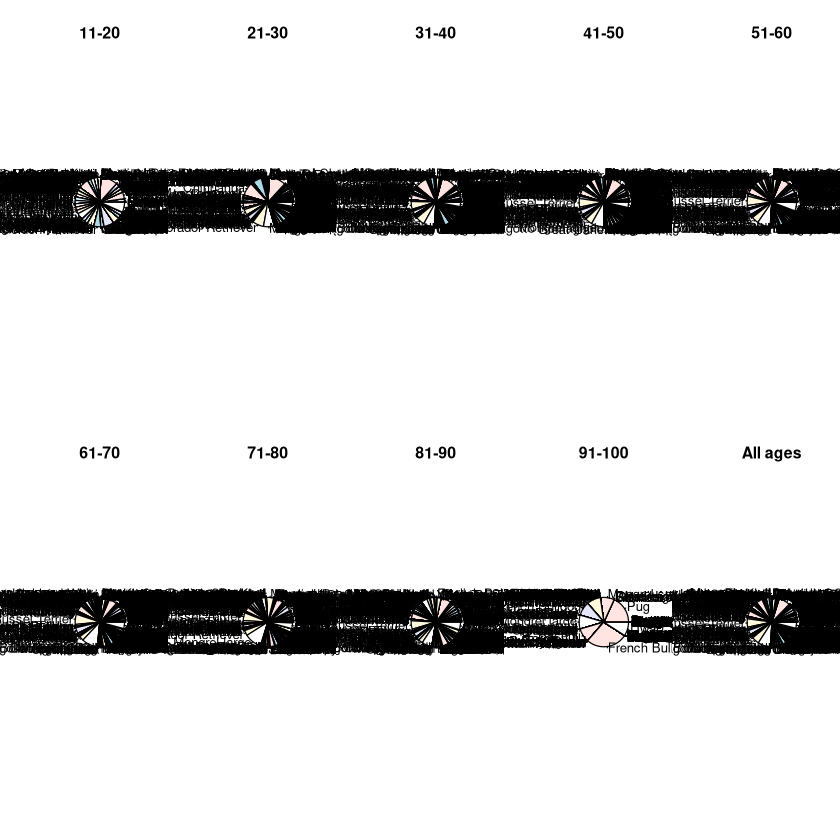

In [26]:
######################################
# Owner Age - Dog Breed Relationship #
######################################

# Generate breeds table for totals
breeds <- table(breed=dogs2020$BREED, age=dogs2020$AGE)
breeds <- cbind(breeds, total = rowSums(breeds)) %>%
as.data.frame()

# Use pie charts to visualise
par(mfrow = c(2,5))
pie(breeds$`11-20`, dogs2020$BREED, main="11-20")
pie(breeds$`21-30`, dogs2020$BREED, main="21-30")
pie(breeds$`31-40`, dogs2020$BREED, main="31-40")
pie(breeds$`41-50`, dogs2020$BREED, main="41-50")
pie(breeds$`51-60`, dogs2020$BREED, main="51-60")
pie(breeds$`61-70`, dogs2020$BREED, main="61-70")
pie(breeds$`71-80`, dogs2020$BREED, main="71-80")
pie(breeds$`81-90`, dogs2020$BREED, main="81-90")
pie(breeds$`91-100`, dogs2020$BREED, main="91-100")
pie(breeds$total, dogs2020$BREED, main="All ages")

# Delete generated table
rm(breeds)


### Here we group subdistricts together and produce metric for the average wealth per city district. 

In [27]:

zh_rg <- readOGR("./data_sources/stzh.adm_stadtkreise_v.json")

# group sub-districts together
list_districts <- list(
  District_1 <- c(
    "Rathaus",
    "Hochschulen",
    "Lindenhof",
    "City"
  ),
  District_2	<- c(
    "Wollishofen",
    "Leimbach",
    "Enge"
  ),
  District_3 <- c(
    "Alt-Wiedikon",
    "Friesenberg",
    "Sihlfeld"
  ),
  District_4 <- c(
    "Werd",
    "Langstrasse",
    "Hard"
  ),
  District_5 <- c(
    "Gewerbeschule",
    "Escher Wyss"
  ),
  District_6	<- c(
    "Unterstrass",
    "Oberstrass",
    "Unterstrass"
  ),
  District_7 <- c(		
    "Fluntern",
    "Hottingen",
    "Hirslanden",
    "Witikon"
  ),
  District_8 <- c(
    "Seefeld",
    "Mühlebach",
    "Weinegg"
  ),
  District_9 <- c(	
    "Albisrieden",
    "Altstetten"
  ),
  District_10 <- c(	
    "Höngg",
    "Wipkingen"
  ),
  District_11 <- c(	
    "Affoltern",
    "Oerlikon",
    "Seebach"
  ),
  District_12 <- c(
    "Saatlen",
    "Schwamendingen-Mitte",
    "Hirzenbach"
  )
)
avg_wealth <- unlist(lapply(seq_len(length(list_districts)), function (z) {
  mean(unlist(lapply(list_districts[[z]], function (y) {
    mean(unlist(lapply(y, function (x) {
      dogs2020[which(x == dogs2020$DISTRICT_NAME),]$WEALTH_T_CHF
    })))
  })))
}))

OGR data source with driver: GeoJSON 
Source: "/home/spam/Documents/programming/R/bdaprojectfork/Big-Data-Analytics/data_sources/stzh.adm_stadtkreise_v.json", layer: "stzh.adm_stadtkreise_v"
with 12 features
It has 3 fields


### This block handles the colouring and generation of a leaflet map that will show a district wise wealth map of Zürich.

In [28]:
bins <- c(0, 25, 30, 50, 60, 75, 100, 120, 150, 175)
pal <- colorBin("Greens", domain = avg_wealth, bins = bins)

map <- leaflet(zh_rg) %>%
  addPolygons(fillColor = ~pal(unlist(avg_wealth)), weight = 2, fillOpacity = 0.9, 
              opacity = 1) %>%
  addTiles() %>% 
  addLegend(colors = pal(unlist(avg_wealth)), labels = zh_rg$kname, title = "Zurich Districts", opacity = 1)


## Leaflet map
This map shows a district wise breakdown of wealth in the City of Zürich. The darker colours represent lower wealth where as the lighter shades represent wealthier districts. In other words, Kreis 12 is the poorest district, whereas Districts 1 and 2 are the wealthiest.


In [31]:
map

HTML widgets cannot be represented in plain text (need html)

# Modelling and Analysis
---
This section of code explores predicting dog breed type, starting from a naive approach and moving onwards.

## K-Nearest Neighbourghs Classification

Our problem is a classification problem because we have labled data and our goal is to predict a class of new data based on known attributes. There are multiple appropriate classification algorithms for such a task, we arbritraily chose KNN to serve as benchmark for the dataset to see what weaknesses we could identify in this model. This was in an attempt to narrow down on a more appropriate model for our data analysis. 

### Model Preparation

In [32]:
dogs2020$COLOR_DOG[1:20]

[1] "weiss/beige"       "beige"             "hellbraun"        
 [4] "beige"             "schwarz/weiss/bra" "braun/weiss"      
 [7] "schwarz/weiss"     "dunkelbraun"       "braun/weiss"      
[10] "schwarz"           "schwarz"           "tricolor"         
[13] "schwarz/weiss"     "beige"             "schwarz/braun/gra"
[16] "rot/schwarz"       "grau"              "schwarz"          
[19] "goldbraun"         "schwarz/braun"

First we recode color to make bigger chunks. Clearing variable i from the enviroment can produce a warning on first-run of the code, however is necessary on subsequent runs. As you can see some dogs are multicoloured so too many distinct colour groups that do not represent the differences between the dogs are formed. To combat this we reduce the colours to only the first listed or primary colour of the dog. 


In [33]:
# Double-colored dogs will be recoded as single-colored with first color taken as main
a <- str_split(dogs2020$COLOR_DOG, "/")
new_colors <- a[[1]][1]
rm(i)
for (i in 2:length(a)) {
  new_colors <- append(new_colors, a[[i]][1])
}

# Put new colors into the dogs data table
dogs2020$COLOR_DOG <- new_colors

Warning message in rm(i):
“object 'i' not found”


As we are going to be putting the data into a knn model, we must first refactor the data into numeric values. This is done for all values we are interested in. The associated labels are saved for breed and breed type.

In [34]:
# Refactoring text attributes to numeric, so that knn can work with it
dogs2020$DISTRICT_NAME <- as.numeric(as.factor(dogs2020$DISTRICT_NAME))
dogs2020$AGE <- as.numeric(as.factor(dogs2020$AGE))
dogs2020$SEX <- as.numeric(as.factor(dogs2020$SEX))
dogs2020$SEX_DOG <- as.numeric(as.factor(dogs2020$SEX_DOG))
dogs2020$COLOR_DOG <- as.numeric(as.factor(dogs2020$COLOR_DOG))
dogs2020$YOB_DOG <- as.numeric(as.factor(dogs2020$YOB_DOG))

# Saving labels in order to see later what numbers represent what breedtypes
breedtype_labels <- as.factor(dogs2020$BREED_TYPE)
dogs2020$BREED_TYPE <- as.numeric(as.factor(dogs2020$BREED_TYPE))

# Saving labels in order to see later what numbers represent what breeds
breed_labels <- as.factor(dogs2020$BREED)
dogs2020$BREED <- as.numeric(as.factor(dogs2020$BREED))

In order to train and test the data, we create training (70%) and testing (30%) datasets.

In [35]:
# Data separation, so that we have testing and training group
dat.d <- sample(1:nrow(dogs2020),size=nrow(dogs2020)*0.7,replace = FALSE) # Randomly select 70% of the data.

# This is the only setting where we are not "cheating" by using dog associated attributes
train.dogs <- dogs2020[dat.d, c("DISTRICT_NAME", "AGE", "SEX")] # 70% training data
test.dogs <- dogs2020[-dat.d, c("DISTRICT_NAME", "AGE", "SEX")] # 30% testing data

# Provide labels for training and testing datasets
train.dogs_labels <- dogs2020[dat.d,BREED]
test.dogs_labels <-dogs2020[-dat.d,BREED]

## Naive Approach
Here we perform a simple k-nearest neighbors classification. We try to directly predict breeds by providing all available parameters to the model (excluding population and economic data because they are district level variables and not granular enough to be used on a per breed basis). The accuracy of this direct prediction is roughly 9.22% because of variations in the random seed while subsetting the data.

In the table below you can see the output of the KNN model prediction for breed vs the real breed values.

In [36]:
# Calculate an approx. k value
k_value <-  sqrt(nrow(dogs2020))

# Perform knn classification using given training data and testing data
knn.test <- knn(train=train.dogs, test=test.dogs, cl=train.dogs_labels, k=k_value)

# Calculate accuracy
ACC.test <- 100 * sum(test.dogs_labels == knn.test) / NROW(test.dogs_labels)

# Print results
table(knn.test ,test.dogs_labels)
ACC.test

        test.dogs_labels
knn.test  2  3  4  6 11 12 14 15 16 17 18 19 21 23 24 27 28 29 30 32 34 37 38
     1    0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
     2    0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
     3    0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
     4    0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
     5    0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
     7    0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
     8    0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
     9    0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
     10   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
     11   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
     12   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
     13   0  0  0  0  0  0  0  0  0  0 

[1] 9.991497

## Increasing Model Accuracy

Based on the relatively low accuracy of ~9% we next decided to try and further separate the dataset into smaller chunks with the idea that it would decrease chunk level variety and potentially increase accuracy. As a chunk seperator we used breed types because it's a natural seperator that existed in our dataset. 

In [43]:
#################################################################
# lets try separating dataset and predict breed type at first,  #
# smaller chunks may lead to more accuracy                      #
#################################################################

# this is the only setting where we are not "cheating" by using dog associated attributes
train.dogs <- dogs2020[dat.d, c("DISTRICT_NAME", "AGE", "SEX")] # 70% training data
test.dogs <- dogs2020[-dat.d,c("DISTRICT_NAME", "AGE", "SEX")] # remaining 30% test data

train.dogs_labels <- dogs2020[dat.d,BREED_TYPE]
test.dogs_labels <-dogs2020[-dat.d,BREED_TYPE]

#aprox k value
k_value <-  sqrt(nrow(dogs2020))

knn.test <- knn(train=train.dogs, test=test.dogs, cl=train.dogs_labels, k=k_value)

ACC.test <- 100 * sum(test.dogs_labels == knn.test)/NROW(test.dogs_labels)

table(knn.test ,test.dogs_labels)

ACC.test

#this yields 62.96% accuracy in preed type prediction
# now we want to predict exact breed 

# we save predicted breedtype, by applying algorythm to whole dataset. (this can open potential for overfitting)
train.dogs$PREDICTED_BREED_TYPE <- knn(train=train.dogs, test=train.dogs, cl=train.dogs_labels, k=k_value)
test.dogs$PREDICTED_BREED_TYPE <- knn(train=train.dogs[,c("DISTRICT_NAME", "AGE", "SEX")], test=test.dogs, cl=train.dogs_labels, k=k_value)

        test.dogs_labels
knn.test   1   3
       1   0   0
       3 354 893

[1] 71.61187

In [44]:
# Perform knn on breed directly
rm(i) # Safety measures
results <- 0 # Safety measures
for (i in 1:length(unique(test.dogs_labels))) # Loops through all unique dog breeds.
{
  if (any(train.dogs$PREDICTED_BREED_TYPE == i) == F) { #Safety measure for the case that there are no dogs in
                                                        # a certain breed type. 
    next()
  }
  
  train.dogs_labels <- dogs2020[dat.d,BREED] #Label assignment for testing and training datasets.
  test.dogs_labels <- dogs2020[-dat.d,BREED]
  
  knn.test <- knn(train=train.dogs[train.dogs$PREDICTED_BREED_TYPE == i], 
                  test=test.dogs[test.dogs$PREDICTED_BREED_TYPE == i], 
                  cl=train.dogs_labels[train.dogs$PREDICTED_BREED_TYPE == i], k=k_value)
  
  ACC.test <- 100 *
    sum(test.dogs_labels[test.dogs$PREDICTED_BREED_TYPE == i] == knn.test)/
    NROW(test.dogs_labels[test.dogs$PREDICTED_BREED_TYPE == i])
  
  table(knn.test ,test.dogs_labels[test.dogs$PREDICTED_BREED_TYPE == i])
  
  results[i] <- ACC.test
}
results

[1] 0

In [38]:
# Doesnt really help.
# The weighted accuracy is (2305 * 9.32754880694143/100 + 6.38297872340426/100 * 47) / 2352
(length(test.dogs_labels[test.dogs$PREDICTED_BREED_TYPE == 1]) * results[1]/100 
  + length(test.dogs_labels[test.dogs$PREDICTED_BREED_TYPE == 3]) * results[3]/100 ) / 
  (length(test.dogs_labels[test.dogs$PREDICTED_BREED_TYPE == 1]) + length(test.dogs_labels[test.dogs$PREDICTED_BREED_TYPE == 3]))
# = 0.09268707, which is not substantially better than approach without breed type grouping.


# Reasonable would be to throw away every breed that comes less than 100 times.
# cause we clearly see that because we dont have more attributes on dog owner levels 
# and more granular data, we are becoming here just inference of distribution of dogs among the
# attributes we use.
# So to improve accuracy it makes sense to reduce the number of possible "answers"


# In order to test it, we have to calculate how many people own each breed
# Count how many people own every breed.
breed_filter <- data.table(aggregate(OWNER_ID ~ BREED, data = dogs2020, FUN = function(x){NROW(x)}))

# Renaming
setnames(breed_filter, old = c("OWNER_ID")
         , new = c("NUMBER_OWNERS"))

# Sorting by number of owners
breed_filter <- breed_filter[order(-rank(NUMBER_OWNERS),)]
breed_filter <- breed_filter[breed_filter[, NUMBER_OWNERS > 100]]

# Leaving in dataset only desired breeds
dogs2020 <- dogs2020[BREED %in% breed_filter[, BREED]]

# 3685 out of 7839 rows are out. (4154 left)
# 15 breeds out of 313 breeds left

# Now we rerun an exact copy of code in the first try

dat.d <- sample(1:nrow(dogs2020),size=nrow(dogs2020)*0.7,replace = FALSE) #random selection of 70% data.

# This is the only setting where we are not "cheating" by using dog associated attributes
train.dogs <- dogs2020[dat.d, c("DISTRICT_NAME", "AGE", "SEX")] # 70% training data
test.dogs <- dogs2020[-dat.d,c("DISTRICT_NAME", "AGE", "SEX")] # Remaining 30% test data

train.dogs_labels <- dogs2020[dat.d,BREED]
test.dogs_labels <-dogs2020[-dat.d,BREED]

#Aprox k value
k_value <-  sqrt(nrow(dogs2020))

knn.test <- knn(train=train.dogs, test=test.dogs, cl=train.dogs_labels, k=k_value)

ACC.test <- 100 * sum(test.dogs_labels == knn.test)/NROW(test.dogs_labels)

table(knn.test ,test.dogs_labels)

ACC.test


[1] NA

        test.dogs_labels
knn.test  29  47  49  69  84 104 123 133 159 174 185 198 199 236 313
     29    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
     47    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
     49    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
     69    9  14   8  87  12  20  40  16  27  46  32  43  56  28  36
     84    1   1   1   1   1   0   0   0   1   2   2   2   5   0   0
     104   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
     123   3   1   2   4   0   4   8   1   3   3   2   8   4   3   1
     133   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
     159   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
     174   1   3   0   6   4   3   7   8  14  17   5  13  17   6   5
     185   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
     198   2   1   1   2   1   1   0   1   0   6   2   3   2   1   3
     199  12  18  16  58  23   8  29  27  45  72  21  56 115  24  50
     236 

[1] 18.52446

In [ ]:
# Accuracy of direct prediction is 17,64%
# Result is better, but still follows the distribution. and is not significantly improven

# Now in an attempt to get more accurate results we split it into chunks, so that breeds
# that come up more often, dont get over preferenced by knn. (Same idea as with breed_type but
# chunking is based on the number of owners of particular breed instead)

# Calculating values for grouping
owners_sum <- sum(breed_filter$NUMBER_OWNERS)
number_groups <- 6
groupsize <- round(owners_sum / number_groups)

# Adding grouping variable
breed_filter[,group:=0]

# In any situation first value is group 1
breed_filter$group[1] <- 1

# Assigning groups
for (i in 2:nrow(breed_filter)) {
  if (sum(breed_filter[group == breed_filter$group[i-1], NUMBER_OWNERS]) > groupsize){
    breed_filter$group[i] <- breed_filter$group[i-1]+1
  } else {
    breed_filter$group[i] <- breed_filter$group[i-1]
  }
}

# Transfer grouping to original dataset
dogs2020 <- merge(dogs2020, breed_filter[,c("BREED", "group")], by = "BREED", all.x = T)

# Rewrite train and test datsets.
# This is the only setting where we are not "cheating" by using dog associated attributes
train.dogs <- dogs2020[dat.d, c("DISTRICT_NAME", "AGE", "SEX", "group")] # 70% training data
test.dogs <- dogs2020[-dat.d,c("DISTRICT_NAME", "AGE", "SEX","group")] # remaining 30% test data

train.dogs_labels <- dogs2020[dat.d,BREED]
test.dogs_labels <-dogs2020[-dat.d,BREED]



# Here we once more execute code very similar to the above part with breed_type
rm(i)
results <- 0
for (i in 1:length(unique(breed_filter$group)))
{
  if (any(train.dogs$group == i) == F) {
    next()
  }
  
  train.dogs_labels <- dogs2020[dat.d,BREED]
  test.dogs_labels <- dogs2020[-dat.d,BREED]
  
  knn.test <- knn(train=train.dogs[train.dogs$group == i], 
                  test=test.dogs[test.dogs$group == i], 
                  cl=train.dogs_labels[train.dogs$group == i], k=k_value)
  
  ACC.test <- 100 *
    sum(test.dogs_labels[test.dogs$group == i] == knn.test)/
    NROW(test.dogs_labels[test.dogs$group == i])
  
  table(knn.test ,test.dogs_labels[test.dogs$group == i])
  
  results[i] <- ACC.test
  
}

# Doesnt really help.
# Weighted accuracy is
(length(test.dogs_labels[test.dogs$group == 1]) * results[1]/100 
  + length(test.dogs_labels[test.dogs$group == 2]) * results[2]/100
  + length(test.dogs_labels[test.dogs$group == 3]) * results[3]/100
  + length(test.dogs_labels[test.dogs$group == 4]) * results[4]/100
  + length(test.dogs_labels[test.dogs$group == 5]) * results[5]/100) / 
    (length(test.dogs_labels[test.dogs$group == 1]) 
  + length(test.dogs_labels[test.dogs$group == 2])
  + length(test.dogs_labels[test.dogs$group == 3])
  + length(test.dogs_labels[test.dogs$group == 4])
  + length(test.dogs_labels[test.dogs$group == 5]))
# = 0.4667201, which is substantially better than 9% we got in the beginning.
# this is the best result we could get. However, the knn bascally still follows the distribution
# of data. and because of that, it would be right to follow the occams razors principle and
# use more simple naive bayes approach, that is made to use the data distributuion for
# following predictions

## Restore Backup
(Delete later once investigation does not directly edit dogs2020)

In [ ]:
dogs2020 = copy(dogs2020_backup)

---

# Interpretation

## Investigation Part 1 : Location, location, location?

Here we are looking at properties at a district level and trying to predicts of properties of these districts like wealth, schools and type of buildings have any bearing on dog ownership. In this section we aggregate the data and produce plots of a linear model. 


### Subset and Aggregate Data

In [ ]:
# First we will need to Subset the Data and Take aggregates to get District Level Statistics
# Relevant Columns w. Duplicates Removed
district_dog <- unique(subset(dogs2020, select=c("OWNER_ID", "DISTRICT_NAME", "WEALTH_T_CHF", "INCOME_T_CHF",
                                                 "BASIC_SCHOOL_PERCENTAGE", "GYMNASIUM_PERCENTAGE", "UNIVERSITY_PERCENTAGE",
                                                 "SINGLE_FAMILY_HOMES", "INFRASTRUCTURE_BUILDINGS", "SMALL_BUILDINGS", "COMMERCIAL_BUILDINGS",
                                                 "APARTMENTS", "FACTORIES_AND_WAREHOUSES", "SPECIAL_ACCOMODATION", "TOTAL_POPULATION",
                                                 "FOREIGN_POPULATION_PERCENTAGE")))

# Aggregation - Count total unique owners and preserve select district data
ddc <- aggregate(OWNER_ID ~ DISTRICT_NAME + WEALTH_T_CHF + INCOME_T_CHF + BASIC_SCHOOL_PERCENTAGE
                 + GYMNASIUM_PERCENTAGE + UNIVERSITY_PERCENTAGE + SINGLE_FAMILY_HOMES
                 + INFRASTRUCTURE_BUILDINGS + SMALL_BUILDINGS + COMMERCIAL_BUILDINGS
                 + APARTMENTS + FACTORIES_AND_WAREHOUSES + SPECIAL_ACCOMODATION + TOTAL_POPULATION + FOREIGN_POPULATION_PERCENTAGE, 
                 data = district_dog, FUN = function(x){NROW(x)})

# Rename Column(s) and Remove Redundant Data
colnames(ddc)[16] <- "TOTAL_UNIQUE_OWNERS"
rm(district_dog)

# Compute Difference
ddc$NON_DOG_OWNERS <- ddc$TOTAL_POPULATION - ddc$TOTAL_UNIQUE_OWNERS
ddc$PERCENT_DOG_OWNERS <- ddc$TOTAL_UNIQUE_OWNERS / ddc$TOTAL_POPULATION

# Compute Total Building Count for Percentages % of Total Buildings and Residential Buildings
ddc$TOTAL_BUILDINGS <- ddc$SINGLE_FAMILY_HOMES + ddc$INFRASTRUCTURE_BUILDINGS + ddc$SMALL_BUILDINGS
                       + ddc$COMMERCIAL_BUILDINGS + ddc$APARTMENTS + ddc$FACTORIES_AND_WAREHOUSES + ddc$SPECIAL_ACCOMODATION
ddc$TOTAL_RESIDENCES <- ddc$SINGLE_FAMILY_HOMES + ddc$APARTMENTS + ddc$SPECIAL_ACCOMODATION

ddc$SINGLE_FAMILY_HOMES_PERCENTAGE <- ddc$SINGLE_FAMILY_HOMES / ddc$TOTAL_BUILDINGS
ddc$SINGLE_FAMILY_HOMES_RESIDENCE_PERCENTAGE <- ddc$SINGLE_FAMILY_HOMES / ddc$TOTAL_RESIDENCES

ddc$APARTMENTS_PERCENTAGE <- ddc$APARTMENTS / ddc$TOTAL_BUILDINGS
ddc$APARTMENTS_RESIDENCE_PERCENTAGE <- ddc$APARTMENTS / ddc$TOTAL_RESIDENCES

ddc$SPECIAL_ACCOMODATION_PERCENTAGE <- ddc$SPECIAL_ACCOMODATION / ddc$TOTAL_BUILDINGS
ddc$SPECIAL_ACCOMODATION_RESIDENCE_PERCENTAGE <- ddc$SPECIAL_ACCOMODATION / ddc$TOTAL_RESIDENCES

# Summary Statistics
summary(ddc)

### Linear Model
Here we produce scatter plots that aim to show dog ownership and it's relationship with enviromental factors such as population, wealth and housing type to name a few. Additionally we perform two linear regressions over wealth and income.

In [ ]:
# Compute Scatter Plots for Preliminary Investigation of Independent Variables
scatter.smooth(x=ddc$TOTAL_POPULATION, y=ddc$PERCENT_DOG_OWNERS, main="Dog Ownership ~ Population")
scatter.smooth(x=ddc$FOREIGN_POPULATION_PERCENTAGE, y=ddc$PERCENT_DOG_OWNERS, main="Dog Ownership ~ Foreign Population %")

scatter.smooth(x=ddc$WEALTH_T_CHF, y=ddc$PERCENT_DOG_OWNERS, main="Dog Ownership ~ Wealth")
scatter.smooth(x=ddc$INCOME_T_CHF, y=ddc$PERCENT_DOG_OWNERS, main="Dog Ownership ~ Income")

scatter.smooth(x=ddc$SINGLE_FAMILY_HOMES_PERCENTAGE, y=ddc$PERCENT_DOG_OWNERS, main="Dog Ownership ~ Single Fam. Home %")
scatter.smooth(x=ddc$SINGLE_FAMILY_HOMES_RESIDENCE_PERCENTAGE, y=ddc$PERCENT_DOG_OWNERS, main="Dog Ownership ~ Single Fam. Home Res. %")

scatter.smooth(x=ddc$APARTMENTS_PERCENTAGE, y=ddc$PERCENT_DOG_OWNERS, main="Dog Ownership ~ Apartments %")
scatter.smooth(x=ddc$APARTMENTS_RESIDENCE_PERCENTAGE, y=ddc$PERCENT_DOG_OWNERS, main="Dog Ownership ~ Apartments Res. %")

scatter.smooth(x=ddc$SPECIAL_ACCOMODATION_PERCENTAGE, y=ddc$PERCENT_DOG_OWNERS, main="Dog Ownership ~ Spec. Acc. %")
scatter.smooth(x=ddc$SPECIAL_ACCOMODATION_RESIDENCE_PERCENTAGE, y=ddc$PERCENT_DOG_OWNERS, main="Dog Ownership ~ Spec. Acc. Res. %")

# Based upon the plots we decide to investigate the quality of wealth and income on Dog Ownership %
cor(ddc$PERCENT_DOG_OWNERS, ddc$WEALTH_T_CHF)
cor(ddc$PERCENT_DOG_OWNERS, ddc$INCOME_T_CHF)

# Two Independent Regressions
linearModWealth <- lm(PERCENT_DOG_OWNERS ~ WEALTH_T_CHF, data=ddc)
linearModIncome <- lm(PERCENT_DOG_OWNERS ~ INCOME_T_CHF, data=ddc)
linearModCombi <- lm(PERCENT_DOG_OWNERS ~ WEALTH_T_CHF + INCOME_T_CHF, data=ddc)

#### Only income seems to have a reliable effect - Rsq: 0.4214, independent variable is statistically significant. Each additional 1000 CHF of income predicts an additional 0.0269% increase in dog ownership.

***

#### Here you can find a summary of the linear model of income.

In [ ]:
summary(linearModIncome)

***

##  Investigation Part 2 : Who's the master anyway?
In this section we start again from square one and investigate the qualities of owners that may determine their choice of dog breed. Using a Naive Bayes model we calculate frequency values for unique dog breeds against certain charateristics of the owners, specifically, age and gender. We also plot these frequency calculations on a per breed basis to better visualise the output of the model.


### Subset Data

In [ ]:
# Subset our Data
dog_owner_chars <- subset(dogs2020, select=c("BREED", "BREED_TYPE", "YOB_DOG", "SEX_DOG", "COLOR_DOG", 
                                             "OWNER_ID", "AGE", "SEX", "WEALTH_T_CHF", "INCOME_T_CHF", 
                                             "DISTRICT_NAME"))

# Remove Outlier Breeds (<20 Entries)
dog_owner_chars <- ddply(dog_owner_chars, "BREED", function(d) {if(nrow(d)>19) d else NULL})
# A helper data frame with Unique Breeds
unique_common_breeds <- unique(subset(dog_owner_chars, select=c("BREED")))

### Naive Bayes Model
Using the naiveBayes() function from the e1071 library we create a dataframe to then loop over and create our frequency plots. We perform this twice, once for the frequency of breeds across age of owner and once for the frequency across genders of owners. 



### Frequency vs Age

In [ ]:
setDT(dog_owner_chars)

# Needs to Be Replaced with Whole Data Set No? Not Just first 100
dog_owner_chars <- subset(dog_owner_chars, select=c("BREED", "AGE", "SEX"))

# Naive Bayes Implementation
nb <- naiveBayes(BREED ~ ., data=dog_owner_chars, laplace = 0, na.action = na.pass)

# Convert nb into a data frame
nb_df_age <- as.data.frame(nb$tables$AGE)

for (i in 1:length(unique_common_breeds$BREED)) {
  breed_name <- unique_common_breeds$BREED[i]
  breed <- which(nb_df_age$Y == breed_name)
  # create data frame for breed values
  d_age <- data.frame(x = nb_df_age[breed,]$AGE, y = nb_df_age[breed,]$Freq)
  # create plot
  plot <- ggplot(d_age, aes(x = x, y = y, group = 1)) + geom_point() + geom_line() + 
    labs(x = "Age group", y = "Frequency", title = paste(breed_name, "-- Frequency Across Age Groups"))
  print(plot)
}


<br>

### Frequency vs Gender

In [ ]:
# Similar approach for sex
nb_df_sex <- as.data.frame(nb$tables$SEX)

for (i in 1:length(unique_common_breeds$BREED)) {
  breed_name <- unique_common_breeds$BREED[i]
  breed <- which(nb_df_sex$Y == breed_name)
  # Create data frame for sex values
  # geom_bar() in ggplot2 takes all of the values that one wants to plot in the bar plot and automatically calculates teh frquency. 
  # Here the frequency is already given. 
  # A workaround is to create a data frame that replicates the frequency value with respect the number given for frequency, such that the right amount of values is output
  rep_freq_f <- cbind("x" = rep(nb_df_sex[breed,]$Freq[1], nb_df_sex[breed,]$Freq[1]*100),
                      "y" = rep("f", nb_df_sex[breed,]$Freq[1]*100))
  rep_freq_m <- cbind("x" = rep(nb_df_sex[breed,]$Freq[2], nb_df_sex[breed,]$Freq[2]*100),
                      "y" = rep("m", nb_df_sex[breed,]$Freq[2]*100))
  freq <- as.data.frame(rbind(rep_freq_f, rep_freq_m))
  # Create plot
  plot <- ggplot(freq, aes(x = y)) + geom_bar() + 
    labs(x = "Sex", y = "Frequency", title = paste(breed_name, "-- Frequency Across Genders")) 
  print(plot)
}

---


---